In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets, models
import os
from PIL import Image
import numpy as np
import json
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import random


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))  # Increased channels
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)  # Adjusted to handle concatenated channels
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits



In [2]:
class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = torch.randint(0, 100000, (1,)).item()  # Generate random seed
        random.seed(seed)  # seed to img transforms
        torch.manual_seed(seed)
        image = self.transform(image)

        random.seed(seed)  # seed to mask transforms
        torch.manual_seed(seed)
        mask = self.transform(mask)

        return image, mask

def json_to_mask(mask_json, image_size):
    """ Convert JSON object to a mask numpy array """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8) 
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  
    return mask

class BuildingCrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_file = os.path.join(self.root_dir, self.files[idx])
        json_file = img_file.replace('.jpg', '.json')
        
        image = Image.open(img_file).convert("RGB")
        
        with open(json_file, 'r') as file:
            mask_json = json.load(file)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)  
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Example setup
transform = Transform()

# Load the dataset
dataset = BuildingCrackDataset(root_dir='/home/adityab/ADRL/A1/Segmented major_crack', transform=Transform())

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25

for epoch in range(epochs):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss / len(val_loader)}")


Epoch 1, Train Loss: 0.15550507605075836, Val Loss: 0.1451498706673467
Epoch 2, Train Loss: 0.08427634090185165, Val Loss: 0.13064325414597988
Epoch 3, Train Loss: 0.053707826882600784, Val Loss: 0.10688049029992071
Epoch 4, Train Loss: 0.2092130184173584, Val Loss: 0.09062274430640214
Epoch 5, Train Loss: 0.08943924307823181, Val Loss: 0.08096303956496508
Epoch 6, Train Loss: 0.049968171864748, Val Loss: 0.07360850246406572
Epoch 7, Train Loss: 0.06280923634767532, Val Loss: 0.09766960915091426
Epoch 8, Train Loss: 0.051743097603321075, Val Loss: 0.06631661061370789
Epoch 9, Train Loss: 0.024094851687550545, Val Loss: 0.06800241496543898
Epoch 10, Train Loss: 0.0345793180167675, Val Loss: 0.06109919073060155
Epoch 11, Train Loss: 0.023604832589626312, Val Loss: 0.055272042740482925
Epoch 12, Train Loss: 0.02997242845594883, Val Loss: 0.05857185795253446
Epoch 13, Train Loss: 0.016835466027259827, Val Loss: 0.054649599383823404
Epoch 14, Train Loss: 0.06578070670366287, Val Loss: 0.049

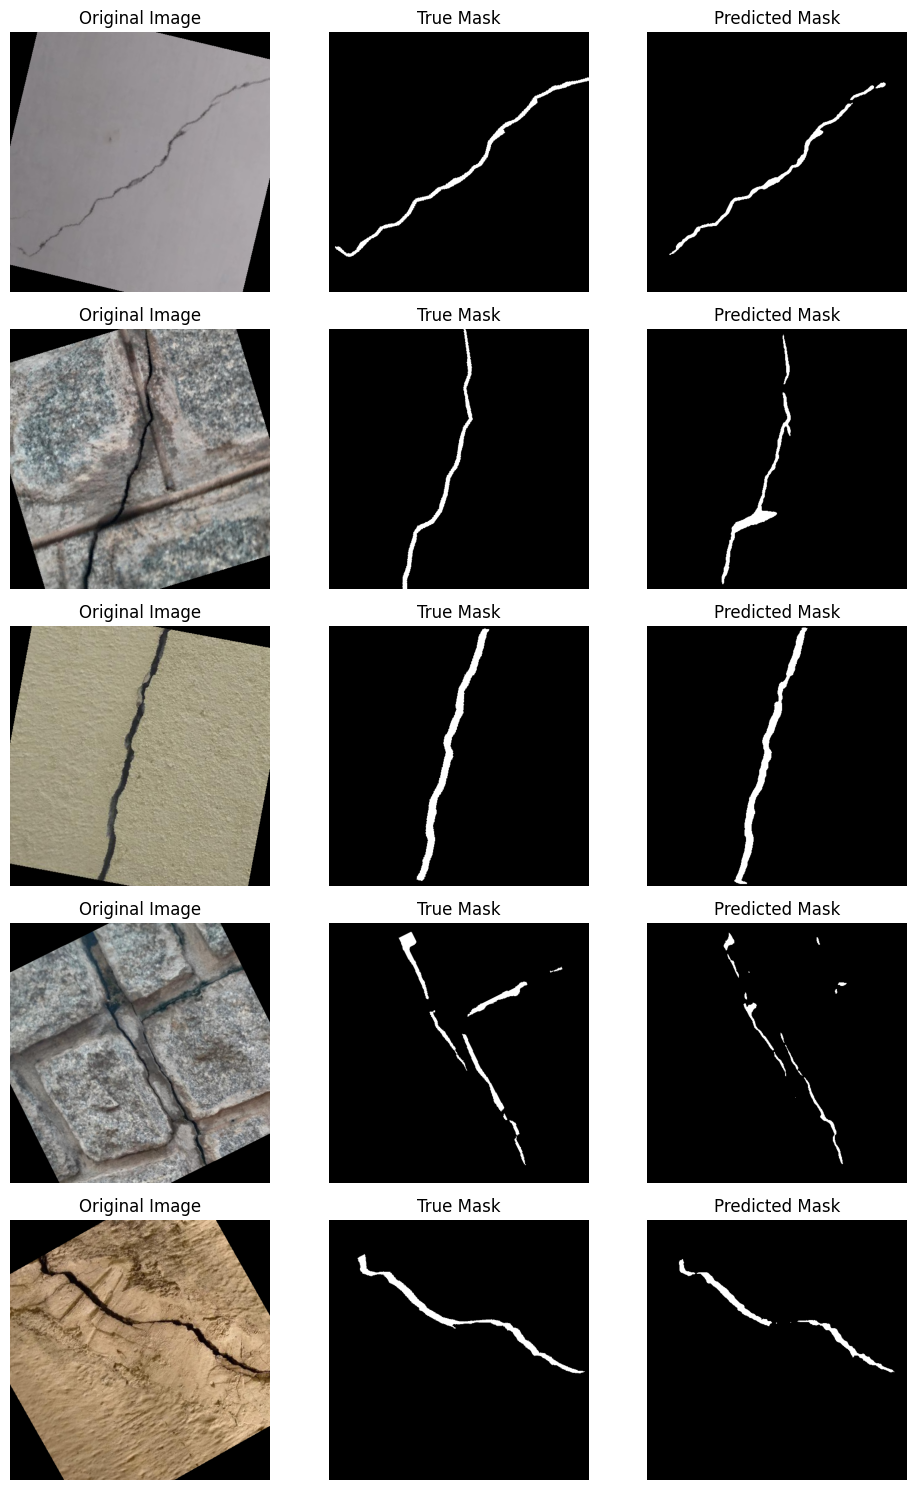

Precision: 0.8849
Recall: 0.7196
F1 Score: 0.7937
Accuracy: 0.9921


In [4]:
def mask_to_image(mask):
    """Convert a torch tensor mask to a numpy image."""
    return mask.squeeze().cpu().numpy()

def visualize_images(images, masks, preds, num_images=5):
    """Visualize a few images, their true masks, and the predicted masks."""
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()  
        true_mask = mask_to_image(masks[i])
        pred_mask = mask_to_image(preds[i])
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(true_mask, cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(true_masks, pred_masks):
    """Calculate precision, recall, F1 score, and accuracy."""
    true_masks = true_masks.cpu().numpy().flatten()  
    pred_masks = pred_masks.cpu().numpy().flatten()  
    
    precision = precision_score(true_masks, pred_masks)
    recall = recall_score(true_masks, pred_masks)
    f1 = f1_score(true_masks, pred_masks)
    accuracy = accuracy_score(true_masks, pred_masks)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

def test_model(model, test_loader, device, threshold=0.5, num_images=5):
    model.eval()
    images_to_show = []
    masks_to_show = []
    preds_to_show = []
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold  
            
            images_to_show.extend(images)
            masks_to_show.extend(masks)
            preds_to_show.extend(preds)
            
            if len(images_to_show) >= num_images:
                break
    
    visualize_images(images_to_show, masks_to_show, preds_to_show, num_images)
    calculate_metrics(torch.cat(masks_to_show), torch.cat(preds_to_show))


test_model(model, test_loader, device, threshold=0.5, num_images=5)


# This one

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets, models
import os
from PIL import Image
import numpy as np
import json
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import random


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))  # Increased channels
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)  # Adjusted to handle concatenated channels
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits



In [2]:
class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = torch.randint(0, 100000, (1,)).item()  # Generate random seed
        random.seed(seed)  # seed to img transforms
        torch.manual_seed(seed)
        image = self.transform(image)

        random.seed(seed)  # seed to mask transforms
        torch.manual_seed(seed)
        mask = self.transform(mask)

        return image, mask

def json_to_mask(mask_json, image_size):
    """ Convert JSON object to a mask numpy array """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8) 
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  
    return mask

class BuildingCrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Only include files with both .jpg and corresponding .json present
        self.files = []
        for f in os.listdir(root_dir):
            if f.endswith('.jpg'):
                json_path = os.path.join(root_dir, f.replace('.jpg', '.json'))
                if os.path.exists(json_path):
                    self.files.append(f)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_file = os.path.join(self.root_dir, self.files[idx])
        json_file = img_file.replace('.jpg', '.json')
        
        image = Image.open(img_file).convert("RGB")

        with open(json_file, 'r') as file:
            mask_json = json.load(file)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)  
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)
        #return transforms.ToTensor()(image), transforms.ToTensor()(mask) / 255.0


# Example setup
transform = Transform()

# Load the dataset
dataset = BuildingCrackDataset(root_dir='/home/adityab/ADRL/final/Segmented major_crack_latest', transform=Transform())

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Epoch 1, Train Loss: 0.1325, Val Loss: 0.2566
Epoch 2, Train Loss: 0.0595, Val Loss: 0.0649
Epoch 3, Train Loss: 0.0530, Val Loss: 0.0569
Epoch 4, Train Loss: 0.0485, Val Loss: 0.0567
Epoch 5, Train Loss: 0.0474, Val Loss: 0.0834
Epoch 6, Train Loss: 0.0468, Val Loss: 0.0554
Epoch 7, Train Loss: 0.0449, Val Loss: 0.0700
Epoch 8, Train Loss: 0.0442, Val Loss: 0.0543
Epoch 9, Train Loss: 0.0439, Val Loss: 0.0511
Epoch 10, Train Loss: 0.0441, Val Loss: 0.1320
Epoch 11, Train Loss: 0.0429, Val Loss: 0.0513
Epoch 12, Train Loss: 0.0415, Val Loss: 0.0497
Epoch 13, Train Loss: 0.0412, Val Loss: 0.0493
Epoch 14, Train Loss: 0.0412, Val Loss: 0.0569
Epoch 15, Train Loss: 0.0396, Val Loss: 0.0488
Epoch 16, Train Loss: 0.0392, Val Loss: 0.0512
Epoch 17, Train Loss: 0.0389, Val Loss: 0.0551
Epoch 18, Train Loss: 0.0375, Val Loss: 0.0475
Epoch 19, Train Loss: 0.0369, Val Loss: 0.0450
Epoch 20, Train Loss: 0.0371, Val Loss: 0.0721
Epoch 21, Train Loss: 0.0360, Val Loss: 0.0438
Epoch 22, Train Loss: 

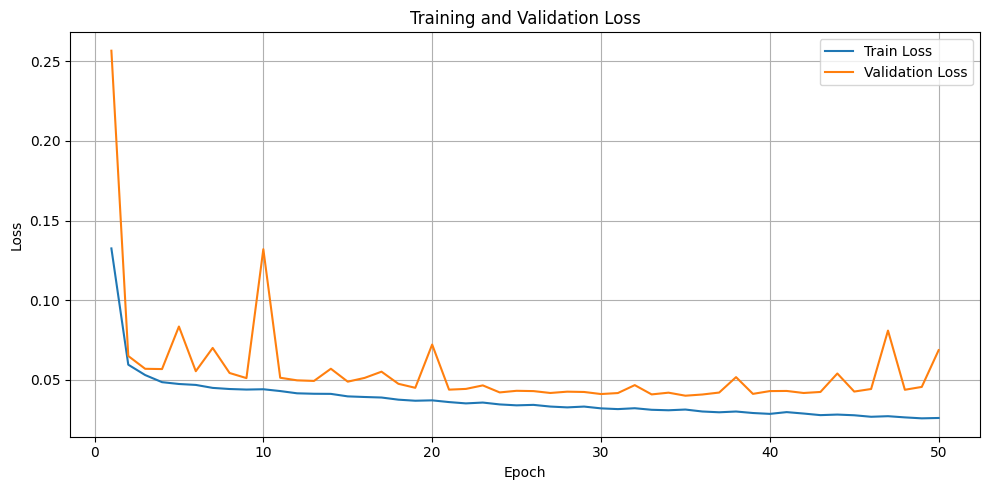

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            running_val_loss += criterion(outputs, masks).item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


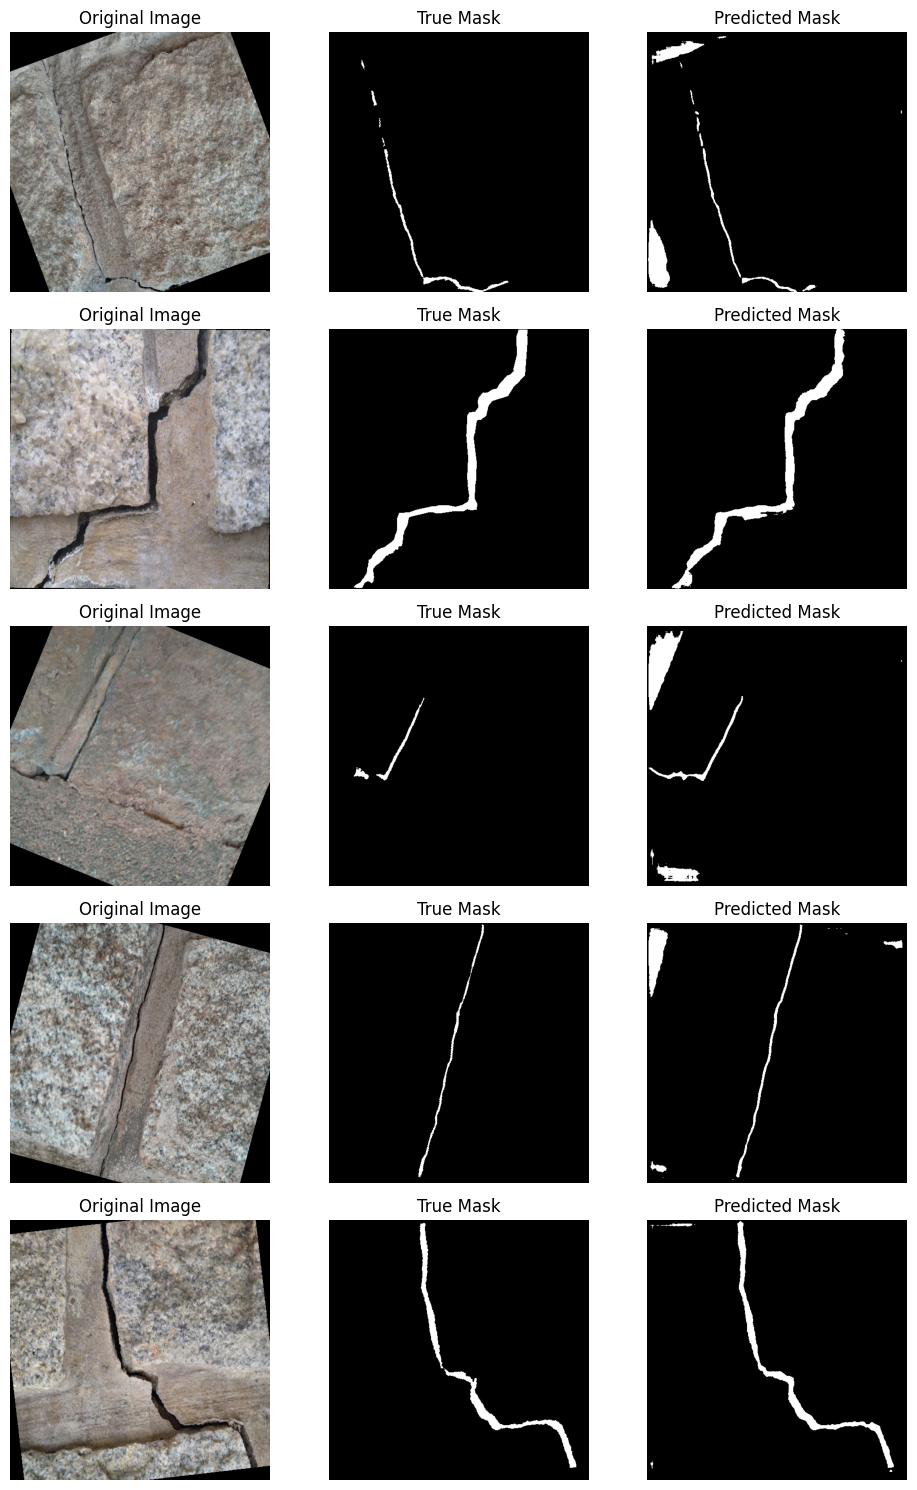

Precision:     0.5114
Recall:        0.6501
F1 Score:      0.5725
Accuracy:      0.9747
Dice Score:    0.5431  (mean per image)
IoU Score:     0.4041  (mIoU per image)


In [8]:
def mask_to_image(mask):
    """Convert a torch tensor mask to a numpy image."""
    return mask.squeeze().cpu().numpy()

def visualize_images(images, masks, preds, num_images=5):
    """Visualize a few images, their true masks, and the predicted masks."""
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()  
        true_mask = mask_to_image(masks[i])
        pred_mask = mask_to_image(preds[i])
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(true_mask, cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def compute_mean_dice_iou(true_masks, pred_masks, eps=1e-7):
    dices = []
    ious = []
    for t, p in zip(true_masks, pred_masks):
        t = t.view(-1).float()
        p = p.view(-1).float()
        intersection = (t * p).sum()
        dice = (2 * intersection + eps) / (t.sum() + p.sum() + eps)
        iou = (intersection + eps) / (t.sum() + p.sum() - intersection + eps)
        dices.append(dice.item())
        ious.append(iou.item())
    return np.mean(dices), np.mean(ious)

def calculate_metrics(true_masks, pred_masks, threshold=0.5):
    """Calculate precision, recall, F1, accuracy, Dice, mIoU."""
    # Binarize masks
    bin_true = (true_masks > threshold).cpu().float()
    bin_pred = pred_masks.cpu().float()

    # Flatten for global metrics
    true_flat = bin_true.view(-1).numpy().astype(np.uint8)
    pred_flat = bin_pred.view(-1).numpy().astype(np.uint8)

    # Global metrics
    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)
    f1 = f1_score(true_flat, pred_flat, zero_division=0)
    accuracy = accuracy_score(true_flat, pred_flat)

    # Per-image averaged Dice and IoU
    dice, miou = compute_mean_dice_iou(bin_true, bin_pred)

    # Print results
    print(f'Precision:     {precision:.4f}')
    print(f'Recall:        {recall:.4f}')
    print(f'F1 Score:      {f1:.4f}')
    print(f'Accuracy:      {accuracy:.4f}')
    print(f'Dice Score:    {dice:.4f}  (mean per image)')
    print(f'IoU Score:     {miou:.4f}  (mIoU per image)')

def test_model(model, test_loader, device, threshold=0.5, num_images=5):
    model.eval()
    all_images = []
    all_masks = []
    all_preds = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_images.extend(images.cpu())
            all_masks.extend(masks.cpu())
            all_preds.extend(preds.cpu())

    # Visualize random N images
    indices = random.sample(range(len(all_images)), num_images)
    vis_images = [all_images[i] for i in indices]
    vis_masks = [all_masks[i] for i in indices]
    vis_preds = [all_preds[i] for i in indices]

    visualize_images(vis_images, vis_masks, vis_preds, num_images)

    # Compute metrics on entire test set
    calculate_metrics(torch.stack(all_masks), torch.stack(all_preds))

# ✅ DO THIS
test_model(model, test_loader, device, threshold=0.5, num_images=5)


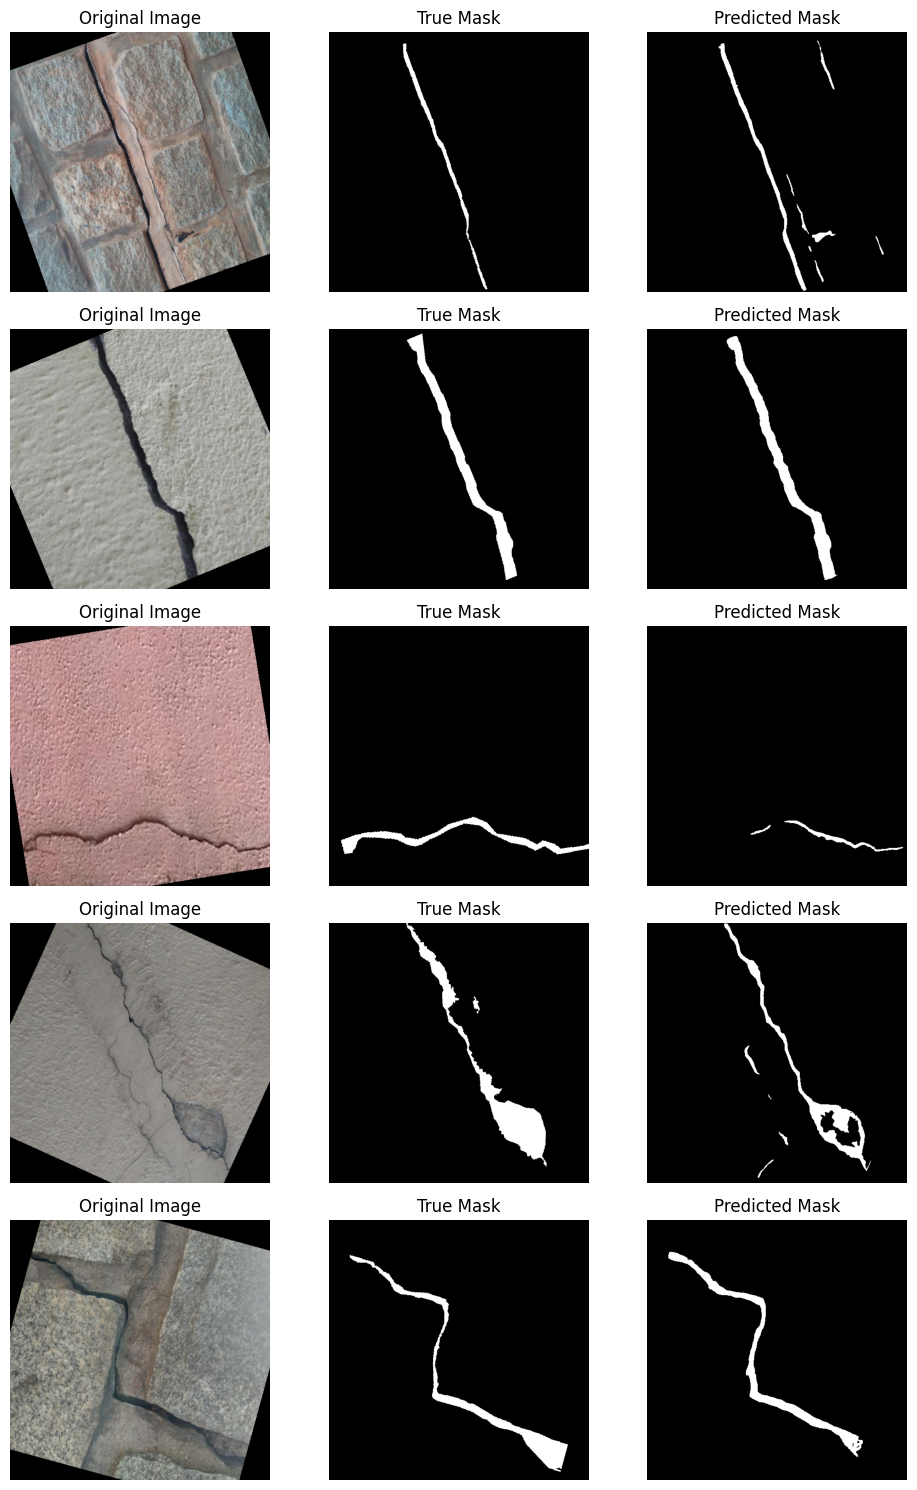

In [17]:
def test_model(model, test_loader, device, threshold=0.5, num_images=5):
    model.eval()
    all_images = []
    all_masks = []
    all_preds = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_images.extend(images.cpu())
            all_masks.extend(masks.cpu())
            all_preds.extend(preds.cpu())

    # Visualize random N images
    indices = random.sample(range(len(all_images)), num_images)
    vis_images = [all_images[i] for i in indices]
    vis_masks = [all_masks[i] for i in indices]
    vis_preds = [all_preds[i] for i in indices]

    visualize_images(vis_images, vis_masks, vis_preds, num_images)
    
test_model(model, test_loader, device, threshold=0.5, num_images=5)

# Not this

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets, models
import os
from PIL import Image
import numpy as np
import json
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import random
import pandas as pd


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))  # Increased channels
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)  # Adjusted to handle concatenated channels
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = self.conv1(torch.cat([x, x4], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x3], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x2], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits



In [2]:
class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = torch.randint(0, 100000, (1,)).item()  
        random.seed(seed)  
        torch.manual_seed(seed)
        image = self.transform(image)

        random.seed(seed)  
        torch.manual_seed(seed)
        mask = self.transform(mask)

        return image, mask

def json_to_mask(mask_json, image_size):
    """ Convert JSON object to a mask numpy array """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8) 
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  
    return mask

class BuildingCrackDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        data_info = pd.read_csv(csv_file)
        data_info['image_path'] = data_info['Filename'].apply(lambda x: os.path.join(root_dir, x))
        
        
        self.data_info = data_info[data_info['image_path'].apply(lambda x: os.path.exists(x) and os.path.exists(x.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        img_file = self.data_info.iloc[idx]['image_path']
        json_file = img_file.replace('.jpg', '.json')
        class_label = self.data_info.iloc[idx]['Composition']
        
        image = Image.open(img_file).convert("RGB")
        with open(json_file, 'r') as file:
            mask_json = json.load(file)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask), class_label
        

transform = Transform()
dataset = BuildingCrackDataset(root_dir='/home/adityab/ADRL/A1/Segmented major_crack', csv_file='/home/adityab/ADRL/building_composition.csv', transform=Transform())


train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        images, masks = batch[:2] 
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            images, masks = batch[:2]  # Also only take the first two elements
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss / len(val_loader)}")



Epoch 1, Train Loss: 0.10518693923950195, Val Loss: 0.18619212958701822
Epoch 2, Train Loss: 0.07673701643943787, Val Loss: 0.09911071205901545
Epoch 3, Train Loss: 0.06765510141849518, Val Loss: 0.10466453666950382
Epoch 4, Train Loss: 0.03869526833295822, Val Loss: 0.08877280257035826
Epoch 5, Train Loss: 0.04767266660928726, Val Loss: 0.07022606553293245
Epoch 6, Train Loss: 0.043781571090221405, Val Loss: 0.06276403303626318
Epoch 7, Train Loss: 0.05592186003923416, Val Loss: 0.05508088246854239
Epoch 8, Train Loss: 0.03902164101600647, Val Loss: 0.05670702719497819
Epoch 9, Train Loss: 0.09688347578048706, Val Loss: 0.05288137677450513
Epoch 10, Train Loss: 0.021994197741150856, Val Loss: 0.0710707801112602
Epoch 11, Train Loss: 0.04693673178553581, Val Loss: 0.07254538549716737
Epoch 12, Train Loss: 0.024606283754110336, Val Loss: 0.18220339295302712
Epoch 13, Train Loss: 0.08104734867811203, Val Loss: 0.10408334625711621
Epoch 14, Train Loss: 0.07137975096702576, Val Loss: 0.109

In [2]:
def mask_to_image(mask):
    """Convert a torch tensor mask to a numpy image."""
    return mask.squeeze().cpu().numpy()

def visualize_images(images, masks, preds, num_images=5):
    """Visualize a few images, their true masks, and the predicted masks."""
    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()  
        true_mask = mask_to_image(masks[i])
        pred_mask = mask_to_image(preds[i])
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(true_mask, cmap='gray')
        axs[i, 1].set_title('True Mask')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_mask, cmap='gray')
        axs[i, 2].set_title('Predicted Mask')
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_model(model, test_loader, device, threshold=0.5, num_images=5):
    model.eval()
    class_metrics = {}
    class_counts = {}
    images_to_show = []
    masks_to_show = []
    preds_to_show = []

    with torch.no_grad():
        for data in test_loader:
            images, masks, classes = data
            if images is None or masks is None or classes is None:
                continue  

            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

        
            for i in range(len(images)):
                if len(images_to_show) < num_images:
                    images_to_show.append(images[i])
                    masks_to_show.append(masks[i])
                    preds_to_show.append(preds[i])

                class_name = classes[i]
                if class_name not in class_metrics:
                    class_metrics[class_name] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
                    class_counts[class_name] = 0

                class_counts[class_name] += 1
                true_mask = masks[i].cpu().numpy().flatten()
                pred_mask = preds[i].cpu().numpy().flatten()

                TP = np.sum((true_mask == 1) & (pred_mask == 1))
                FP = np.sum((true_mask == 0) & (pred_mask == 1))
                TN = np.sum((true_mask == 0) & (pred_mask == 0))
                FN = np.sum((true_mask == 1) & (pred_mask == 0))

                class_metrics[class_name]['TP'] += TP
                class_metrics[class_name]['FP'] += FP
                class_metrics[class_name]['TN'] += TN
                class_metrics[class_name]['FN'] += FN

    
    if images_to_show:
        visualize_images(images_to_show, masks_to_show, preds_to_show, num_images)


    for class_name, metrics in class_metrics.items():
        precision = metrics['TP'] / (metrics['TP'] + metrics['FP']) if (metrics['TP'] + metrics['FP']) > 0 else 0
        recall = metrics['TP'] / (metrics['TP'] + metrics['FN']) if (metrics['TP'] + metrics['FN']) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])

        print(f"Class {class_name}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, Count: {class_counts[class_name]}")


csv_path = '/home/adityab/ADRL/building_composition.csv'

test_model(model, test_loader, device, threshold=0.5, num_images=5)


Class Cement:
Precision: 0.8106, Recall: 0.5578, F1 Score: 0.6609, Accuracy: 0.9834, Count: 71.0000, 

Class Concrete:
Precision: 0.9593, Recall: 0.7775, F1 Score: 0.8589, Accuracy: 0.9863, Count: 5.0000, 

Class Stone:
Precision: 0.7453, Recall: 0.6772, F1 Score: 0.7096, Accuracy: 0.9902, Count: 7.0000, 

Class Brick:
Precision: 0.8066, Recall: 0.2478, F1 Score: 0.3792, Accuracy: 0.9837, Count: 4.0000, 



In [7]:
import pandas as pd

df = pd.read_csv('/home/adityab/ADRL/building_composition.csv')

unique_classes = df['Composition'].unique()

print(f'There are {len(unique_classes)} unique classes.')

print(f'The unique classes are: {unique_classes}')
import pandas as pd

class_counts = df['Composition'].value_counts()

print("Number of files per class:")
print(class_counts)



There are 4 unique classes.
The unique classes are: ['Cement' 'Concrete' 'Brick' 'Stone']
Number of files per class:
Composition
Cement      438
Stone        61
Brick        43
Concrete     38
Name: count, dtype: int64
